##Input

In [0]:
mnt_sim_years = 50
Hs_lim = 2.5
Tp_lim = 6
min_duration = 12
column_names = ['Hs', 'Tp']


# database_name =                   lookup copernicus
#longitude_min = 
#longitude_max =
#latitude_min =
# latitude_max = 

##Libraries

In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
from joblib import Parallel, delayed 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer
import mlflow
import plotly.express as px
import matplotlib.pyplot as plt

#Libraries for copernicus data extraction
#import copernicusmarine as cm

##Copernicus data extraction (work in progress)

In [0]:
#cm.login(username = 'brosenberg1', 
#         password= 'Allseas123!')

In [0]:
# df_raw = cm.read_dataframe(
#   dataset_id="cmems_mod_glo_wav_anfc_0.083deg_PT3H-i",
#   variables=["VHM0", "VTPK"],
#   minimum_longitude=-110.54330133693617, #specify
#   maximum_longitude=-110.54330133693617, #specify
#   minimum_latitude=8.493861792320827, #specify
#   maximum_latitude=8.493861792320827, #specify
#   start_datetime="1980-01-1T00:00:00",
#   end_datetime="2025-01-1T00:00:00",
# )

# df_raw['DateTime'] = pd.to_datetime(df_raw['time']).dt.tz_localize("UTC")
# df_raw['Month'] = df_raw['DateTime'].dt.month
# df_raw = df_raw.set_index('DateTime')
# df_raw = df_raw.rename(columns={'VHM0': 'Hs', 'VTPK': 'Tp'})
# df_raw = df_raw[['Month','Hs', 'Tp']]
# df_raw = df_raw.iloc[::2] #Pick every second time point

It is also possible to store the data in databricks, but i don't see why we would do this. Now we only import it in our code

##Data input and preprocessing 

Obsolete if copernicus data import works

In [0]:
path = '/Workspace/Users/brb@allseas.com/Markov Switching Workability/data/Timeseries_Waves_ShellCrux.csv'
df_raw = pd.read_csv(path)
df_raw['DateTime'] = pd.to_datetime(df_raw['time']).dt.tz_localize("UTC")
df_raw['Month'] = df_raw['DateTime'].dt.month
df_raw = df_raw.set_index('DateTime')
df_raw = df_raw.rename(columns={'VHM0': 'Hs', 'VTPK': 'Tp'})
df_raw = df_raw[['Month','Hs', 'Tp']]
df_raw = df_raw.iloc[::2] #Pick every second time point

Create output df

In [0]:
begin_year = df_raw.index[0].year
end_year = begin_year + mnt_sim_years
date_rng = pd.date_range(start=f'{begin_year}-01-01', end=f'{end_year}-01-03', freq='6H').tz_localize("UTC")

# Create a DataFrame with the date range as the index
output_df = pd.DataFrame(date_rng, columns=['DateTime'])
output_df['Month'] = output_df['DateTime'].dt.month

output_df = output_df.set_index('DateTime')


Monthly dataframes

In [0]:
monthly_dataframes = {}
monthly_output_df = {}
for month, data in df_raw.groupby('Month'):
    monthly_output_df[month] = output_df.copy()
    monthly_dataframes[month] = data.copy()

Transform data

In [0]:
boxcox_dfs        = {}   # month → DataFrame with original columns, Hs_boxcox, and Tp_boxcox
boxcox_models_Hs  = {}   # month → fitted PowerTransformer for Hs (for inverse_transform)
boxcox_models_Tp  = {}  

for month, df in monthly_dataframes.items():

    # 1️⃣ Safety checks – Box-Cox needs strictly positive data
    if (df['Hs'] <= 0).any():
        raise ValueError(f"Month {month}: Hs contains non-positive values, Box-Cox transformation cannot be applied.")
    
    if (df['Tp'] <= 0).any(): # Added safety check for Tp
        raise ValueError(f"Month {month}: Tp contains non-positive values, Box-Cox transformation cannot be applied.")

    # 2️⃣ Fit fresh, separate transformers for Hs and Tp for this month
    
    # Transformer for Hs
    pt_hs = PowerTransformer(method="box-cox", standardize=True)  # Set standardize to False if you don’t want z-scaling
    # Ensure 'Hs' is 2D array for fit_transform, e.g., df[['Hs']]
    transformed_Hs = pt_hs.fit_transform(df[['Hs']]).ravel()
    
    # Transformer for Tp
    pt_tp = PowerTransformer(method="box-cox", standardize=True)  # Set standardize to False if you don’t want z-scaling
    # Ensure 'Tp' is 2D array for fit_transform, e.g., df[['Tp']]
    transformed_Tp = pt_tp.fit_transform(df[['Tp']]).ravel()

    # 3️⃣ Save results
    out = df.copy()  # Contains original columns

    out["Hs_boxcox"] = transformed_Hs
    out["Tp_boxcox"] = transformed_Tp  # DataFrame `out` now contains both transformed series

    # Store the DataFrame (which includes both transformations)
    boxcox_dfs[month]    = out              # For day-to-day analysis, contains original df + transformed Hs & Tp
    
    # Store the correctly fitted transformers
    boxcox_models_Hs[month] = pt_hs            # Hs transformer, so you can invert Hs_boxcox later
    boxcox_models_Tp[month] = pt_tp            # Tp transformer, so you can invert Tp_boxcox later

Grid search 

In [0]:
# Your parameter grid (using the smaller one as per your last instruction)
param_grid = {
    'k_regimes': [2],
    'order': [2]
}

n_splits = 2
n_jobs_parallel = 12  # As per your original script
verbose_parallel = 1 # As per your original script


#--------------------------------------------------------------------------------#
#--This function evaluates the model for a given month with certain parameters---#
#--------------------------------------------------------------------------------#

def evaluate_model_params_bic(params, endog_data, cv_splitter, n_splits_func_scope): # Added n_splits_func_scope
    # Extract parameters from the grid
    k_regimes = params['k_regimes']
    order = params['order']
    fold_scores_bic = []

    # print(f"Starting param eval: k={k_regimes}, order={order} for data of length {len(endog_data)}") # Verbose print

    # Ensure enough data for cross-validation (initial check based on overall length)
    if len(endog_data) < n_splits_func_scope + 1: # Use passed n_splits
        # print(f"Data too short for CV: len={len(endog_data)}, n_splits={n_splits_func_scope}")
        return {'params': params, 'score': np.inf, 'month_data_too_short_initial': True}

    # Perform cross-validation
    for train_index, test_index in cv_splitter.split(endog_data):
        train_data = endog_data[train_index]

        # A simplified check:
        min_data_needed = k_regimes * (order + 1) + (k_regimes**2 - k_regimes) + 10 # Heuristic
        # min_data_needed = k_regimes * (order + 1 (for const) + 1 (for var)) + (k_regimes**2 - k_regimes) + 10 # More robust heuristic
        
        if len(train_data) < min_data_needed or len(train_data) < order + 5 or len(train_data) == 0:
            # print(f"  Fold: Train data too short: len={len(train_data)}, min_needed_heuristic={min_data_needed}")
            fold_scores_bic.append(np.inf)
            continue

        try:
            # Fit the model on training data
            model = MarkovAutoregression(
                endog=train_data,
                k_regimes=k_regimes,
                order=order,
                switching_ar=True,       # All AR parameters switch
                switching_variance=True, # Variance switches
                switching_trend=False    # No trend considered, or a single global trend if specified
            )

            # Fit the model (with two stages of fitting)
            # Increased maxiter for robustness, reduced maxfun for speed if powell is slow
            res1 = model.fit(method='powell', maxfun=3000, maxiter=1000, disp=False) # xtol, ftol defaults are fine
            res2 = model.fit(start_params=res1.params, method='bfgs', maxiter=1000, disp=False) # gtol, norm, epsilon defaults fine
            
            fold_scores_bic.append(res2.bic)  # Save the BIC for this fold

        except Exception as e:
            # print(f"  Exception encountered for k={k_regimes}, order={order} in fold: {type(e).__name__} - {str(e)[:100]}")
            fold_scores_bic.append(np.inf)

    # Compute the mean BIC score over all folds
    valid_scores = [s for s in fold_scores_bic if s is not None and not np.isinf(s) and not np.isnan(s)]
    mean_bic = np.mean(valid_scores) if len(valid_scores) > 0 else np.inf

    # print(f"Finished param eval: k={k_regimes}, order={order} → Mean BIC = {mean_bic:.2f} from {len(valid_scores)} valid folds")

    return {'params': params, 'score': mean_bic, 'month_data_too_short_initial': False}


#--------------------------------------------------------------------------------#
#---------This part loops over the months the perform the function above---------#
#--------------------------------------------------------------------------------#

# Set MLflow experiment once (replace with your path if needed)
# The path you provided seems specific to a user. Ensure this is accessible or adjust.
try:
    mlflow.set_experiment("/Users/brb@allseas.com/MarkovAutoregression_GridSearch_Hs_Tp")
except Exception as e:
    print(f"Could not set MLflow experiment. Ensure MLflow server is running and path is correct. Error: {e}")
    print("Proceeding without MLflow logging for this run.")
    mlflow_active = False
else:
    mlflow_active = True

all_best_results_by_variable = {
    'Hs_boxcox': {},
    'Tp_boxcox': {}
}
target_variables = ['Hs_boxcox', 'Tp_boxcox'] # Define which variables to process

# Assuming boxcox_dfs is a dictionary: month -> DataFrame (with Hs_boxcox and Tp_boxcox columns)
# Example: boxcox_dfs = {1: pd.DataFrame({'Hs_boxcox': np.random.rand(100), 'Tp_boxcox': np.random.rand(100)})}

for month, df in boxcox_dfs.items(): # Ensure boxcox_dfs is defined and populated
    print(f"\nProcessing Month: {month}")
    for target_var_name in target_variables:
        print(f"  Target Variable: {target_var_name}")

        if target_var_name not in df.columns:
            print(f"    Skipping {target_var_name} for month {month}: column not found.")
            all_best_results_by_variable[target_var_name][month] = {
                'params': None, 'score': np.inf, 'error': f'{target_var_name} column not found'
            }
            continue

        current_timeseries_data = df[target_var_name].values

        # Preprocess to keep only last 3/4 of each month's data (as per your n_obs_month * (3//4) logic)
        n_obs_month_full = len(current_timeseries_data)
        
        # Ensure there's enough data overall before trying to take a portion
        if n_obs_month_full == 0:
            print(f"    Skipping {target_var_name} for month {month}: no data points.")
            all_best_results_by_variable[target_var_name][month] = {
                'params': None, 'score': np.inf, 'error': 'No data points for this month and variable'
            }
            continue

        # Using integer division for n_last_portion to ensure it's an indexable integer
        n_last_portion = n_obs_month_full * 3 // 4 
        if n_last_portion == 0 and n_obs_month_full > 0 : # if 3/4 is 0, take at least 1 if data exists
             n_last_portion = n_obs_month_full # or some other minimum, like 1 if n_obs_month_full > 0

        current_timeseries_data_processed = current_timeseries_data[-n_last_portion:]
        n_obs_processed = len(current_timeseries_data_processed)

        if n_obs_processed < n_splits + 1: # Check based on processed data length
            print(f"    Skipping {target_var_name} for month {month}: insufficient data points after processing ({n_obs_processed}). Min needed for {n_splits} splits: {n_splits + 1}.")
            all_best_results_by_variable[target_var_name][month] = {
                'params': None, 'score': np.inf, 'error': f'Insufficient data after processing ({n_obs_processed})'
            }
            continue

        # Prepare TimeSeriesSplit for cross-validation
        # effective_test_size calculation: ensure it's at least 1 if possible
        # (n_obs_processed - order_max) // n_splits might be safer if order is large relative to n_obs_processed
        # However, TimeSeriesSplit's test_size is number of samples, not a percentage here.
        # Original logic: (n_obs_month - 1) // n_splits. Adapting to n_obs_processed.
        if n_obs_processed // n_splits > 0 :
             effective_test_size = (n_obs_processed - 1) // n_splits # Original logic adapted
             if effective_test_size == 0 and n_obs_processed > n_splits : # Ensure test size is at least 1 if possible
                 effective_test_size = 1
        else: # Not enough data to form meaningful splits with test data
            print(f"    Skipping {target_var_name} for month {month}: Not enough data ({n_obs_processed}) to create {n_splits} splits with test data.")
            all_best_results_by_variable[target_var_name][month] = {
                'params': None, 'score': np.inf, 'error': f'Cannot create {n_splits} splits with test data from {n_obs_processed} points'
            }
            continue
        
        if effective_test_size == 0: # If still zero, indicates a problem
            print(f"    Skipping {target_var_name} for month {month}: effective_test_size is 0 with {n_obs_processed} points for {n_splits} splits.")
            all_best_results_by_variable[target_var_name][month] = {
                'params': None, 'score': np.inf, 'error': f'Effective test size is 0'
            }
            continue

        tscv_month = TimeSeriesSplit(n_splits=n_splits, test_size=effective_test_size)

        # Prepare parameter combinations to grid search
        param_combinations = [{'k_regimes': k, 'order': o} for k in param_grid['k_regimes'] for o in param_grid['order']]

        print(f"    Running grid search for {target_var_name}, month {month} with {len(param_combinations)} parameter combos on {n_obs_processed} data points...")

        # Parallel execution of grid search
        results_list_month = Parallel(n_jobs=n_jobs_parallel, verbose=verbose_parallel)(
            delayed(evaluate_model_params_bic)(params, current_timeseries_data_processed, tscv_month, n_splits) for params in param_combinations
        )

        # Filter valid results
        valid_results_month = [r for r in results_list_month if r and not r.get('month_data_too_short_initial', False) and r.get('score') is not None and not np.isinf(r['score']) and not np.isnan(r['score'])]

        if not valid_results_month:
            print(f"    No valid fits for {target_var_name}, month {month}.")
            all_best_results_by_variable[target_var_name][month] = {
                'params': None, 'score': np.inf, 'error': 'No valid model fits'
            }
            continue

        # Sort by best BIC score (lower is better)
        sorted_results_month = sorted(valid_results_month, key=lambda x: x['score'])
        best_result_month = sorted_results_month[0] # Already filtered for non-inf scores

        all_best_results_by_variable[target_var_name][month] = best_result_month
        print(f"    Best parameters for {target_var_name}, month {month}: {best_result_month['params']} with mean BIC: {best_result_month['score']:.4f}")

#--------------------------------------------------------------------------------#
#--------------This part logs the results in a databricks experiment-------------#
#--------------------------------------------------------------------------------#
        if mlflow_active and best_result_month and best_result_month.get('params'):
            # Log the best result with a month tag in MLflow
            with mlflow.start_run():
                mlflow.set_tag("month", str(month))
                mlflow.set_tag("target_variable", target_var_name)
                run_name = (f"Var_{target_var_name}_Month_{month}_"
                            f"kReg_{best_result_month['params']['k_regimes']}_"
                            f"ord_{best_result_month['params']['order']}")
                mlflow.set_tag("mlflow.runName", run_name)
                
                mlflow.log_params(best_result_month['params'])
                mlflow.log_metric('mean_bic', best_result_month['score'])
                mlflow.log_metric('n_obs_full_month', n_obs_month_full) # Original full month observations
                mlflow.log_metric('n_obs_processed', n_obs_processed) # Observations used for this run
                mlflow.log_metric('effective_test_size', effective_test_size)
                mlflow.log_metric('n_splits_cv', n_splits) # Renamed for clarity
                mlflow.log_metric('n_jobs_parallel', n_jobs_parallel)
                # mlflow.log_metric('verbose_parallel', verbose_parallel) # Typically not logged

            print(f"    Logged best params for {target_var_name}, month {month} to MLflow.")
        elif not mlflow_active:
             print(f"    MLflow is not active. Skipping logging for {target_var_name}, month {month}.")


# Summary output
print("\n" + "="*50)
print("Summary of best parameters per month and variable:")
print("="*50)
for target_var, monthly_results in all_best_results_by_variable.items():
    print(f"\n--- Target Variable: {target_var} ---")
    if not monthly_results:
        print("  No results for this variable.")
        continue
    for month, result in monthly_results.items():
        if result and result.get('params') and result.get('score') is not None and not np.isinf(result['score']):
            params_str = ", ".join(f"{k}={v}" for k, v in result['params'].items())
            print(f"  Month {month}: Params [{params_str}], Mean BIC = {result['score']:.4f}")
        else:
            err_msg = result.get('error', 'No suitable model found or error in processing') if result else 'No result object'
            print(f"  Month {month}: {err_msg}")



Processing Month: 1
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 1 with 1 parameter combos on 4092 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 1: {'k_regimes': 2, 'order': 2} with mean BIC: 1110.8720
    Logged best params for Hs_boxcox, month 1 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 1 with 1 parameter combos on 4092 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 1: {'k_regimes': 2, 'order': 2} with mean BIC: 3171.0211
    Logged best params for Tp_boxcox, month 1 to MLflow.

Processing Month: 2
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 2 with 1 parameter combos on 3729 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 2: {'k_regimes': 2, 'order': 2} with mean BIC: 1113.3269
    Logged best params for Hs_boxcox, month 2 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 2 with 1 parameter combos on 3729 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 2: {'k_regimes': 2, 'order': 2} with mean BIC: 2715.9948
    Logged best params for Tp_boxcox, month 2 to MLflow.

Processing Month: 3
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 3 with 1 parameter combos on 4092 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 3: {'k_regimes': 2, 'order': 2} with mean BIC: 1305.1169
    Logged best params for Hs_boxcox, month 3 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 3 with 1 parameter combos on 4092 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 3: {'k_regimes': 2, 'order': 2} with mean BIC: 3133.7419
    Logged best params for Tp_boxcox, month 3 to MLflow.

Processing Month: 4
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 4 with 1 parameter combos on 3960 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 4: {'k_regimes': 2, 'order': 2} with mean BIC: 1428.7741
    Logged best params for Hs_boxcox, month 4 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 4 with 1 parameter combos on 3960 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 4: {'k_regimes': 2, 'order': 2} with mean BIC: 2859.1986
    Logged best params for Tp_boxcox, month 4 to MLflow.

Processing Month: 5
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 5 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 5: {'k_regimes': 2, 'order': 2} with mean BIC: 1499.2490
    Logged best params for Hs_boxcox, month 5 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 5 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 5: {'k_regimes': 2, 'order': 2} with mean BIC: 2266.3419
    Logged best params for Tp_boxcox, month 5 to MLflow.

Processing Month: 6
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 6 with 1 parameter combos on 3870 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 6: {'k_regimes': 2, 'order': 2} with mean BIC: 1478.2357
    Logged best params for Hs_boxcox, month 6 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 6 with 1 parameter combos on 3870 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 6: {'k_regimes': 2, 'order': 2} with mean BIC: 3009.6012
    Logged best params for Tp_boxcox, month 6 to MLflow.

Processing Month: 7
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 7 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 7: {'k_regimes': 2, 'order': 2} with mean BIC: 1274.6766
    Logged best params for Hs_boxcox, month 7 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 7 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 7: {'k_regimes': 2, 'order': 2} with mean BIC: 2984.1731
    Logged best params for Tp_boxcox, month 7 to MLflow.

Processing Month: 8
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 8 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 8: {'k_regimes': 2, 'order': 2} with mean BIC: 1488.2537
    Logged best params for Hs_boxcox, month 8 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 8 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 8: {'k_regimes': 2, 'order': 2} with mean BIC: 3463.2984
    Logged best params for Tp_boxcox, month 8 to MLflow.

Processing Month: 9
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 9 with 1 parameter combos on 3870 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 9: {'k_regimes': 2, 'order': 2} with mean BIC: 1148.1020
    Logged best params for Hs_boxcox, month 9 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 9 with 1 parameter combos on 3870 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 9: {'k_regimes': 2, 'order': 2} with mean BIC: 3159.2116
    Logged best params for Tp_boxcox, month 9 to MLflow.

Processing Month: 10
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 10 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 10: {'k_regimes': 2, 'order': 2} with mean BIC: 1447.0986
    Logged best params for Hs_boxcox, month 10 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 10 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 10: {'k_regimes': 2, 'order': 2} with mean BIC: 3372.5362
    Logged best params for Tp_boxcox, month 10 to MLflow.

Processing Month: 11
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 11 with 1 parameter combos on 3870 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 11: {'k_regimes': 2, 'order': 2} with mean BIC: 1175.4592
    Logged best params for Hs_boxcox, month 11 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 11 with 1 parameter combos on 3870 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 11: {'k_regimes': 2, 'order': 2} with mean BIC: 3105.8430
    Logged best params for Tp_boxcox, month 11 to MLflow.

Processing Month: 12
  Target Variable: Hs_boxcox
    Running grid search for Hs_boxcox, month 12 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Hs_boxcox, month 12: {'k_regimes': 2, 'order': 2} with mean BIC: 1267.2948
    Logged best params for Hs_boxcox, month 12 to MLflow.
  Target Variable: Tp_boxcox
    Running grid search for Tp_boxcox, month 12 with 1 parameter combos on 3999 data points...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


    Best parameters for Tp_boxcox, month 12: {'k_regimes': 2, 'order': 2} with mean BIC: 3285.7183
    Logged best params for Tp_boxcox, month 12 to MLflow.

Summary of best parameters per month and variable:

--- Target Variable: Hs_boxcox ---
  Month 1: Params [k_regimes=2, order=2], Mean BIC = 1110.8720
  Month 2: Params [k_regimes=2, order=2], Mean BIC = 1113.3269
  Month 3: Params [k_regimes=2, order=2], Mean BIC = 1305.1169
  Month 4: Params [k_regimes=2, order=2], Mean BIC = 1428.7741
  Month 5: Params [k_regimes=2, order=2], Mean BIC = 1499.2490
  Month 6: Params [k_regimes=2, order=2], Mean BIC = 1478.2357
  Month 7: Params [k_regimes=2, order=2], Mean BIC = 1274.6766
  Month 8: Params [k_regimes=2, order=2], Mean BIC = 1488.2537
  Month 9: Params [k_regimes=2, order=2], Mean BIC = 1148.1020
  Month 10: Params [k_regimes=2, order=2], Mean BIC = 1447.0986
  Month 11: Params [k_regimes=2, order=2], Mean BIC = 1175.4592
  Month 12: Params [k_regimes=2, order=2], Mean BIC = 1267.2

#Fit MarkovAutoregression

In [0]:
def fit_one_month_msm(m: int,
                      series_name: str, # Added series_name
                      boxcox_dfs: dict[int, pd.DataFrame],
                      ar_order: int,    # Specific order for this series & month
                      k_regimes: int    # Specific k_regimes for this series & month
                     ) -> tuple[int, str, dict]: # Return month, series_name, and params
    """
    Fit MarkovAutoregression(ar_order, k_regimes) on month m’s specified series.
    """
    print(f"Fitting month {m}, series {series_name}, order {ar_order}, k_regimes {k_regimes}")
    
    # Ensure the series exists and has data
    if series_name not in boxcox_dfs[m].columns:
        print(f"Series {series_name} not found in boxcox_dfs for month {m}. Skipping.")
        return m, series_name, {"error": f"Series {series_name} not found"}
    
    y = (boxcox_dfs[m][series_name]
            .replace([np.inf, -np.inf], np.nan)
            .dropna()
            .reset_index(drop=True))
    
    if len(y) < ar_order + k_regimes + 10: # Basic check for sufficient data
        print(f"Insufficient data for month {m}, series {series_name} (len: {len(y)}). Skipping fit.")
        return m, series_name, {"error": "Insufficient data points after NaN drop"}

    # Ensure MarkovAutoregression is imported and available
    try:
        from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
    except ImportError:
        print("MarkovAutoregression could not be imported from statsmodels.")
        raise

    model = MarkovAutoregression(
        endog=y,
        k_regimes=k_regimes,
        order=ar_order,
        trend='n', # No trend; if you need intercept, use 'c' and adjust extract_params
        switching_variance=True,
        switching_ar=True,
    )
    
    try:
        res1 = model.fit(method='powell', maxfun=5000, maxiter=1500, xtol=1e-4, ftol=1e-4, disp=False)
        res = model.fit(start_params=res1.params, method='bfgs', maxiter=1500, gtol=1e-6, norm=np.inf, epsilon=1e-8, disp=False)
    except Exception as e:
        print(f"Error fitting model for month {m}, series {series_name}: {e}")
        return m, series_name, {"error": str(e)}
    
    A_raw = res.regime_transition.transpose()[0].copy()
    pi0  = res.initial_probabilities

    k = res.k_regimes
    A = np.clip(A_raw, 0.0, 1.0)
    for i in range(k):
        row_sum = A[i].sum()
        if np.isclose(row_sum, 0.0) or row_sum == 0: # Handle exact zero sum
            A[i, :] = 1.0 / k
        else:
            A[i, :] = A[i, :] / row_sum

    params_dict = {
        "ar_params_flat":      res.params,
        "transition_matrix":   A,
        "k_regimes":           res.k_regimes,
        "order":               res.order,
        "n_obs":               len(y),
        "initial_probabilities": pi0,
        "series_name": series_name # Store for clarity
    }
    return m, series_name, params_dict

# ------------------------------------------------------------------
# 2)  Parallel wrapper - Modified to handle multiple series
# ------------------------------------------------------------------
def fit_all_monthly_msm_models(
    boxcox_dfs: dict[int, pd.DataFrame],
    all_optimal_params: dict[str, dict[int, dict]], # e.g., all_months_best_results
    target_series_names: list[str] = ["Hs_boxcox", "Tp_boxcox"],
    n_jobs: int = -1
) -> dict[str, dict[int, dict]]:
    """
    Fits MSM models for each target series for each month using optimal parameters.
    all_optimal_params should be like: {'Hs_boxcox': {month: {'params': {'k_regimes':kr, 'order':o}}}, ...}
    """
    tasks = []
    for series_name in target_series_names:
        if series_name not in all_optimal_params:
            print(f"Optimal parameters for series {series_name} not found. Skipping.")
            continue
        
        series_optimal_params = all_optimal_params[series_name]
        for m in range(1, 13): # Assuming months 1-12
            if m not in series_optimal_params:
                print(f"Optimal parameters for month {m}, series {series_name} not found. Skipping.")
                continue
            
            # Ensure 'params' key and sub-keys 'k_regimes', 'order' exist
            if 'params' not in series_optimal_params[m] or \
               'k_regimes' not in series_optimal_params[m]['params'] or \
               'order' not in series_optimal_params[m]['params']:
                print(f"Incomplete optimal parameters for month {m}, series {series_name}. Skipping.")
                continue

            current_params = series_optimal_params[m]['params']
            ar_order = current_params['order']
            k_regimes = current_params['k_regimes']
            
            tasks.append(delayed(fit_one_month_msm)(
                m, series_name, boxcox_dfs, ar_order, k_regimes
            ))

    if not tasks:
        print("No tasks generated for fitting models.")
        return {}

    parallel_results = Parallel(n_jobs=n_jobs)(tasks)

    # Restructure results
    final_models = {series_name: {} for series_name in target_series_names}
    for m_res, series_name_res, params_res in parallel_results:
        if "error" not in params_res : # Store only successful fits
             if series_name_res in final_models: # Ensure series_name_res is valid
                 final_models[series_name_res][m_res] = params_res
        else:
            print(f"Skipped storing result for month {m_res}, series {series_name_res} due to error: {params_res['error']}")


    return final_models

# --- Fit models for both Hs_boxcox and Tp_boxcox ---
# This now uses the all_months_best_results structure directly
all_series_monthly_models = fit_all_monthly_msm_models(
    boxcox_dfs,
    all_best_results_by_variable, # Pass the full nested dict
    target_series_names=["Hs_boxcox", "Tp_boxcox"],
    n_jobs=20 # Or your desired number of jobs
)

#print("\nFitted Models Structure:")
# print(all_series_monthly_models) # Potentially very large output

##Simulation with parameters from fitting

Extracting parameters from fitting

In [0]:
def extract_params(res_params, k_regimes, order):
    params_per_regime = {}
    for regime in range(k_regimes):
        
        intercept = res_params.get(f"const[{regime}]", 0)  # Uncomment this when an intercept is included

        # Extract AR coefficients for this regime
        ar_coefs = [res_params.get(f"ar.L{i+1}[{regime}]", 0) for i in range(order)]
        
        # Extract sigma values for this regime (using the same format as AR coefficients)
        sigma = np.sqrt(res_params.get(f"sigma2[{regime}]", 1))

        
        params_per_regime[regime] = {
            "intercept": intercept,
            "ar_coefs": ar_coefs,
            "sigma": sigma
        }
    return params_per_regime

In [0]:
def extract_params(res_params, k_regimes, order):
    """Extracts model parameters (intercept, AR coefficients, sigma) for each regime."""
    params_per_regime = {}
    for regime in range(k_regimes):
        # If trend='c' was used in MarkovAutoregression, intercept would be 'const[{regime}]'
        # With trend='n', explicit intercept is typically zero unless part of AR definition.
        # For simplicity, assuming intercept is not explicitly fitted or is part of res_params if model implies it.
        # If you used trend='c', uncomment:
        # intercept = res_params.get(f"const[{regime}]", 0) 
        intercept = 0 # Assuming trend='n' means no separate intercept parameter here.

        ar_coefs = [res_params.get(f"ar.L{i+1}[{regime}]", 0) for i in range(order)]
        
        # sigma2 is variance, so sqrt for sigma (std dev)
        sigma = np.sqrt(res_params.get(f"sigma2[{regime}]", 1.0)) # Default to 1 if not found, to avoid sqrt(0) issues with missing params

        params_per_regime[regime] = {
            "intercept": intercept,
            "ar_coefs": ar_coefs,
            "sigma": sigma
        }
    return params_per_regime

Simulating 

In [0]:
def simulate_regime_path(length, init_probs, trans_matrix, random_state=48):
    """Simulates a sequence of regimes given initial probabilities and a transition matrix."""
    rng = np.random.default_rng(random_state)
    regimes = np.zeros(length, dtype=int)
    if not init_probs.any(): # Handle case where init_probs might be all zero or invalid
        print("Warning: Initial probabilities are invalid. Defaulting to uniform distribution.")
        init_probs = np.ones(len(trans_matrix)) / len(trans_matrix)
    
    # Ensure init_probs sum to 1
    if not np.isclose(np.sum(init_probs), 1.0):
        print(f"Warning: Initial probabilities {init_probs} do not sum to 1. Normalizing.")
        init_probs = init_probs / np.sum(init_probs)

    regimes[0] = rng.choice(len(init_probs), p=init_probs)
    for t in range(1, length):
        regimes[t] = rng.choice(len(init_probs), p=trans_matrix[regimes[t-1]])
    return regimes

In [0]:
def simulate_msar_with_regimes(ts_length, regime_sequence, params_per_regime, order, series_name, random_state=48):
    """
    Simulate time series using a given regime sequence for regime switching.
    Modified to output series_name specific columns.
    """
    if random_state is None:
        rng = np.random.default_rng()
    elif isinstance(random_state, int):
        rng = np.random.default_rng(random_state)
    else:
        rng = random_state

    Y = np.zeros(ts_length)
    regimes_sampled = np.asarray(regime_sequence).copy()

    # Initialize first p values (e.g., with unconditional mean of the first regime or zeros)
    # For simplicity, initializing with zeros.
    Y[:order] = 0.0

    for t in range(order, ts_length):
        current_regime_idx = regimes_sampled[t]
        p = params_per_regime[current_regime_idx]

        eps = rng.normal(0, p['sigma'])
        ar_term = 0
        for lag_index in range(order):
            coef = p['ar_coefs'][lag_index]
            lagged_value = Y[t - lag_index - 1]
            ar_term += coef * lagged_value
        
        Y[t] = p['intercept'] + ar_term + eps # Include intercept if it's non-zero

    df_sim = pd.DataFrame({
        f'{series_name}_simulated': Y,
        f'{series_name}_Regime': regimes_sampled
    })
    return df_sim

Running simulation

In [0]:
all_series_sim_dfs = []

target_series_for_simulation = ["Hs_boxcox", "Tp_boxcox"]

for series_name_to_sim in target_series_for_simulation:
    print(f"\nSimulating for series: {series_name_to_sim}")
    if series_name_to_sim not in all_series_monthly_models:
        print(f"  No models found for {series_name_to_sim}. Skipping simulation.")
        continue

    monthly_models_for_series = all_series_monthly_models[series_name_to_sim]
    all_blocks = []

    for month in range(1, 13):
        if month not in monthly_models_for_series:
            print(f"  Model for month {month} (series {series_name_to_sim}) not found. Skipping.")
            continue

        model_params_for_month = monthly_models_for_series[month]
        if "error" in model_params_for_month:
            print(
                f"  Skipping month {month} for series {series_name_to_sim} "
                f"due to model fitting error: {model_params_for_month['error']}"
            )
            continue

        k_regimes = model_params_for_month['k_regimes']
        order = model_params_for_month['order']

        # ────────────────────────────────────────────────────────────────────
        # Use the pre‐built 6‐hourly “future” grid (monthly_output_df) to find the datetime index
        # ────────────────────────────────────────────────────────────────────
        future_grid = monthly_output_df[month]
        month_mask_out = (future_grid["Month"] == month)
        datetime_index_for_month = future_grid.index[month_mask_out]
        n_obs = len(datetime_index_for_month)

        if n_obs == 0:
            print(
                f"  No “future” timestamps in month {month}, series {series_name_to_sim}. Skipping simulation."
            )
            continue

        # ────────────────────────────────────────────────────────────────────
        # Simulate using the already‐fitted MSM parameters for this month
        # ────────────────────────────────────────────────────────────────────
        res_params_flat = model_params_for_month['ar_params_flat']
        params_per_regime = extract_params(res_params_flat, k_regimes, order)

        regime_path = simulate_regime_path(
            n_obs,
            model_params_for_month['initial_probabilities'],
            model_params_for_month['transition_matrix']
        )

        sim_df_month = simulate_msar_with_regimes(
            n_obs,
            regime_path,
            params_per_regime,
            order,
            series_name_to_sim
        )

        # Attach the “month” column and the actual 6‐hourly timestamps
        sim_df_month['month'] = month
        sim_df_month['DateTime'] = datetime_index_for_month

        # ────────────────────────────────────────────────────────────────────
        # **CRITICAL**: set the index to the real datetimes BEFORE concatenating
        # ────────────────────────────────────────────────────────────────────
        sim_df_month = sim_df_month.set_index('DateTime')
        # Now sim_df_month.index is a DatetimeIndex for that calendar month, in ascending order

        all_blocks.append(sim_df_month)

    # Once we have appended all 12 calendar‐month blocks for this series,
    # concatenate them along rows and then sort by index one final time:
    if len(all_blocks) == 0:
        print(f"  No data simulated for series {series_name_to_sim}.")
        continue

    df_one_series_simulated_year = pd.concat(all_blocks)
    df_one_series_simulated_year = df_one_series_simulated_year.sort_index()
    all_series_sim_dfs.append(df_one_series_simulated_year)

# ─────────────────────────────────────────────────────────────────────────────
# Now combine all series (Hs_boxcox vs Tp_boxcox) side‐by‐side, aligning on the datetime index.
# ─────────────────────────────────────────────────────────────────────────────
if len(all_series_sim_dfs) == 0:
    raise ValueError("No simulated series data found in all_series_sim_dfs.")

df_simulated_year = pd.concat(all_series_sim_dfs, axis=1)
df_simulated_year = df_simulated_year.sort_index()  # ensure strict chronological order

df_simulated_year = df_simulated_year.drop(columns=['month'])
df_simulated_year['month'] = df_simulated_year.index.month




Simulating for series: Hs_boxcox

Simulating for series: Tp_boxcox


Back transformation

In [0]:
df_simulated_year['Hs_original'] = np.nan
df_simulated_year['Tp_original'] = np.nan

for month in range(1, 13):
    # Create a boolean mask of “which rows in df_simulated_year belong to this calendar month”
    month_mask = df_simulated_year['month'] == month

    # ─── Inverse‐transform Hs_boxcox_simulated → Hs_original ─────────────────────
    hs_sim_vals = df_simulated_year.loc[month_mask, 'Hs_boxcox_simulated'].values.reshape(-1, 1)
    pt_hs = boxcox_models_Hs[month]  # previously‐fitted PowerTransformer for Hs
    hs_inv = pt_hs.inverse_transform(hs_sim_vals).flatten()
    df_simulated_year.loc[month_mask, 'Hs_original'] = hs_inv

    # ─── Inverse‐transform Tp_boxcox_simulated → Tp_original ─────────────────────
    tp_sim_vals = df_simulated_year.loc[month_mask, 'Tp_boxcox_simulated'].values.reshape(-1, 1)
    pt_tp = boxcox_models_Tp[month]  # previously‐fitted PowerTransformer for Tp
    tp_inv = pt_tp.inverse_transform(tp_sim_vals).flatten()
    df_simulated_year.loc[month_mask, 'Tp_original'] = tp_inv

/databricks/python/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/sklearn/base.py:4

In [0]:
df_simulated_year

,Hs_boxcox_simulated,Hs_boxcox_Regime,Tp_boxcox_simulated,Tp_boxcox_Regime,month,Hs_original,Tp_original
DateTime,,,,,,,
1980-01-01 00:00:00+00:00,0.000000,1,0.000000,1,1,1.346116,8.236147
1980-01-01 06:00:00+00:00,0.000000,1,0.000000,1,1,1.346116,8.236147
1980-01-01 12:00:00+00:00,-0.069490,1,-0.096278,1,1,1.291342,7.922447
1980-01-01 18:00:00+00:00,0.201518,1,0.334430,1,1,1.514865,9.413792
1980-01-02 00:00:00+00:00,0.381103,1,0.363242,1,1,1.678225,9.521956
...,...,...,...,...,...,...,...
2030-01-02 00:00:00+00:00,-0.488733,1,-0.852058,1,1,0.995552,5.807222
2030-01-02 06:00:00+00:00,-0.774435,1,-1.073669,1,1,0.825413,5.291107
2030-01-02 12:00:00+00:00,-1.178534,1,-1.409988,1,1,0.623271,4.585843


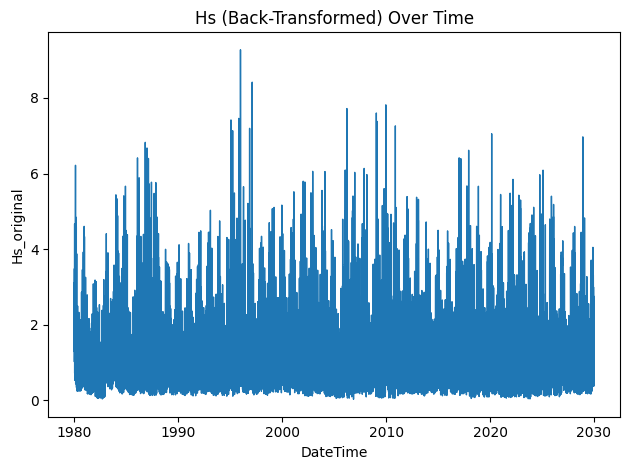

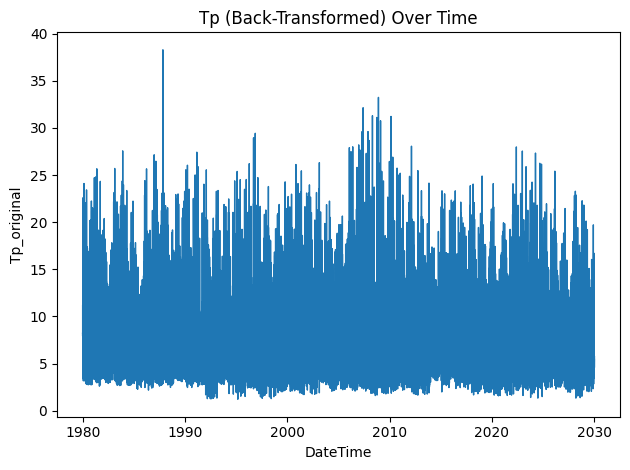

In [0]:
fig, ax = plt.subplots()
ax.plot(df_simulated_year.index, df_simulated_year['Hs_original'], linewidth=1)
ax.set_title('Hs (Back-Transformed) Over Time')
ax.set_xlabel('DateTime')
ax.set_ylabel('Hs_original')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(df_simulated_year.index, df_simulated_year['Tp_original'], linewidth=1)
ax.set_title('Tp (Back-Transformed) Over Time')
ax.set_xlabel('DateTime')
ax.set_ylabel('Tp_original')
plt.tight_layout()
plt.show()

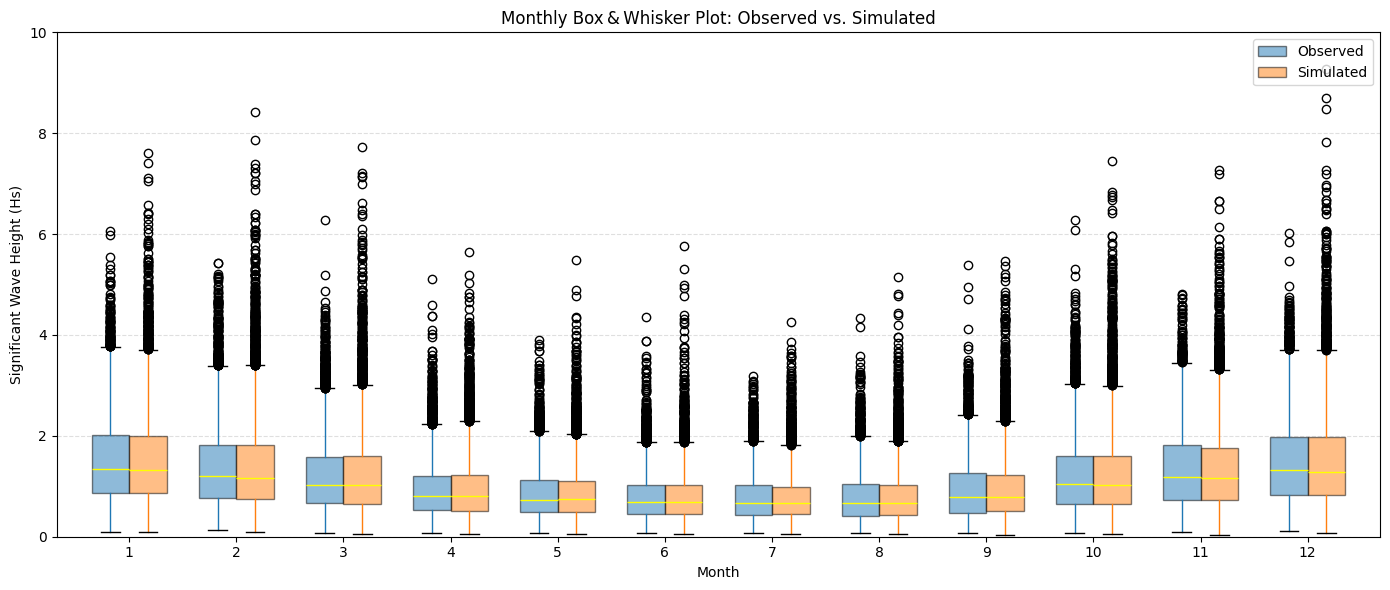

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) get your monthly arrays
def get_monthly_data(df, col):
    return [df[df.index.month == m][col].dropna().values
            for m in range(1, 13)]

obs_data = get_monthly_data(df_raw, 'Hs')
sim_data = get_monthly_data(df_simulated_year, 'Hs_original')

# 2) build a figure with 12 grouped boxplots
fig, ax = plt.subplots(figsize=(14, 6))

# positions for the 12 months
months = np.arange(1, 13)
width = 0.35

# boxplot for observed (shifted left)
bp_obs = ax.boxplot(
    obs_data,
    positions=months - width/2,
    widths=width,
    patch_artist=True,
    showfliers=True,
    whiskerprops=dict(color='C0'),
    boxprops=dict(facecolor='C0', alpha=0.5),
    medianprops=dict(color='yellow')
)

# boxplot for simulated (shifted right)
bp_sim = ax.boxplot(
    sim_data,
    positions=months + width/2,
    widths=width,
    patch_artist=True,
    showfliers=True,
    whiskerprops=dict(color='C1'),
    boxprops=dict(facecolor='C1', alpha=0.5),
    medianprops=dict(color='yellow')
)

# 3) cosmetic
ax.set_xticks(months)
ax.set_xticklabels([str(m) for m in months])
ax.set_xlabel('Month')
ax.set_ylabel('Significant Wave Height (Hs)')

ax.set_ylim([0,10])
ax.set_title('Monthly Box & Whisker Plot: Observed vs. Simulated')
ax.legend(
    [bp_obs["boxes"][0], bp_sim["boxes"][0]],
    ['Observed','Simulated'],
    loc='upper right'
)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [0]:
obs_data = df_raw['Hs']
sim_data = df_simulated_year['Hs_original']

##WOW